In [41]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from collections import OrderedDict

In [11]:
datapath = Path("/data/merged_performances/baseline_performances/")

In [12]:
%%time

results = {}
for outer_directory in datapath.glob("*"): 
    drug = outer_directory.stem
    results[drug] = {}
    
    for inner_directory in outer_directory.glob("*"): 
        tissue = inner_directory.stem
        results[drug][tissue] = {}
        
        data = np.load(inner_directory / "baseline_performance.npz")
        
        for model in ['Linear Regression', 'Nearest Neighbour', 'Random Forest','Neural Network']: 
            zero = data[f"{model}-zero"]
            zero = np.vstack([zero for _ in range(20)]) # There is only 1 possible zero-shot, so expanding for all trials
            performance = np.mean(np.hstack([zero, data[f"{model}-fewshot"]]), axis=0)

            results[drug][tissue][model] = performance    

CPU times: user 51.2 ms, sys: 0 ns, total: 51.2 ms
Wall time: 50.3 ms


In [20]:
datapath = Path("/data/merged_performances/TCRP_performances/")

In [19]:
for i in os.listdir("/data/merged_performances/TCRP_performances/"):
    drug_path = "/data/merged_performances/TCRP_performances/" + i + "/PDTC"
    for j in os.listdir(drug_path):
        os.system("mv {} {}/TCRP_performance.npz".format(drug_path+'/'+j,drug_path))

In [21]:
%%time

for outer_directory in datapath.glob("*"): 
    drug = outer_directory.stem
    for inner_directory in outer_directory.glob("*"): 
        tissue = inner_directory.stem
        
        data = np.load(inner_directory / "TCRP_performance.npz")
        
        for model in ['TCRP']: 
            zero = data[f"{model}-zero"]
            new_data = data["TCRP-fewshot"] 
            fewshot = np.vstack([new_data for _ in range(10)])
            zero = np.vstack([zero for _ in range(10)]) # There is only 1 possible zero-shot, so expanding for all trials
            performance = np.mean(np.hstack([zero, fewshot]), axis=0)
            
            results[drug][tissue][model] = performance    

CPU times: user 17.9 ms, sys: 135 µs, total: 18 ms
Wall time: 17.2 ms


## Collapsing across all results

In [23]:
TCRP_results = {'TCRP': []}

for drug, d in results.items(): 
    for tissue, d in d.items(): 
        for model, p in d.items(): 
            if model == "TCRP":
                p = np.nan_to_num(p)
                TCRP_results[model].append(p)

for model, ps in TCRP_results.items(): 
    TCRP_results[model] = np.vstack(ps)

In [24]:
TCRP_results

{'TCRP': array([[-2.09929615e-01,  2.67281933e-01,  2.42554538e-01,
          2.54201003e-01,  2.78510044e-01,  2.79157874e-01,
          2.80652956e-01,  2.80828322e-01,  2.80285678e-01,
          2.80969229e-01,  2.80796510e-01],
        [ 5.25114954e-01,  3.36295584e-01,  1.49678278e-01,
          1.96566769e-01,  2.54684041e-01,  1.86459500e-01,
          2.74931184e-01,  3.37300723e-01,  2.92213460e-01,
          2.72346166e-01,  2.64827479e-01],
        [ 4.25306708e-01,  1.76941075e-01,  2.07727281e-01,
          2.60429619e-01,  2.92090551e-01,  3.02320578e-01,
          2.93711733e-01,  3.07476972e-01,  3.03204788e-01,
          3.01116621e-01,  3.02403807e-01],
        [ 3.05246562e-01,  1.34468927e-01,  2.30755390e-01,
          2.91870064e-01,  3.37650742e-01,  3.38528483e-01,
          3.38352143e-01,  3.38657163e-01,  2.42067782e-01,
          2.78056477e-01,  2.78003283e-01],
        [ 2.62346685e-01,  4.75865636e-02,  9.43821877e-02,
          1.09529295e-01,  1.4283053

In [26]:
results_by_baseline = {'Linear Regression': [], 'Nearest Neighbour': [], 'Random Forest': [],"TCRP":[],"Neural Network":[]}

for drug, d in results.items(): 
    for tissue, d in d.items(): 
        for model, p in d.items(): 
            p = np.nan_to_num(p)
            results_by_baseline[model].append(p)
            
for model, ps in results_by_baseline.items(): 
    results_by_baseline[model] = np.vstack(ps)

In [ ]:
results_by_baseline.keys()

dict_keys(['Linear Regression', 'Nearest Neighbour', 'Random Forest', 'TCRP', 'Neural Network'])

In [214]:
import scipy.stats as st
std_list = {"Linear Regression": [],"Nearest Neighbour": [],'Random Forest': [], 'TCRP': [], 'Neural Network': []}
for model, ps in results_by_baseline.items(): 
    min_ci = []
    max_ci = []
    for i in range(ps.shape[1]):
        data = ps[:,i]
        ci = st.t.interval(0.95, len(data)-1, loc=np.mean(data), scale=st.sem(data))
        min_ci.append(ci[0])
        max_ci.append(ci[1])
    std_list[model].extend([np.array(min_ci),np.array(max_ci)])

In [183]:
std_list["Linear Regression"]

[array([-0.00653996, -0.0012489 ,  0.04169447,  0.06270162,  0.06279854,
         0.03252732,  0.02421161,  0.01766693,  0.00909129,  0.01366686,
         0.01176834]),
 array([0.19923396, 0.22506922, 0.21372185, 0.21726479, 0.21624312,
        0.20752243, 0.21276098, 0.21828272, 0.21046802, 0.21595778,
        0.21478594])]

In [186]:
results_by_baseline["Neural Network"].shape

(17, 11)

Text(0.5, 0, 'Number of PDTC models')

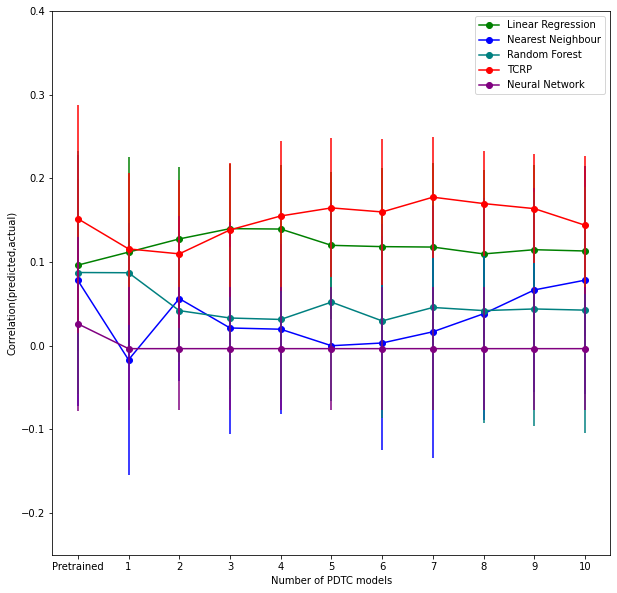

In [215]:
%matplotlib inline
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
color_dict={"Linear Regression":"green","Neural Network":"purple","Random Forest":"teal","Nearest Neighbour": "blue","TCRP":"red"}
for model, ps in results_by_baseline.items(): 
    p = ax.plot(np.arange(11), np.mean(ps, axis=0),label=model,marker='o',color=color_dict[model])
    ax.vlines(np.arange(11),std_list[model][0],std_list[model][1],color=color_dict[model])
ax.legend()
labels = ['Pretrained'] + [str(i) for i in range(1, 11)]
ax.set_xticks(np.arange(11))
ax.set_xticklabels(labels)
plt.ylim((-0.25,0.4))
plt.ylabel("Correlation(predicted,actual)")
plt.xlabel("Number of PDTC models")

In [187]:
TCRP_drug ={}
linear_drug = {}
RF_drug = {}
KNN_drug = {}
NN_drug = {}
for key,value in results.items():
    if False in np.isnan(results[key]['PDTC']["Nearest Neighbour"]):
        p = np.nan_to_num(results[key]["PDTC"]["Nearest Neighbour"])
    TCRP_drug[key] = np.mean(results[key]["PDTC"]["TCRP"])
    linear_drug[key] = np.mean(results[key]["PDTC"]["Linear Regression"])
    NN_drug[key] = np.mean(results[key]["PDTC"]["Neural Network"])
    RF_drug[key] = np.mean(results[key]["PDTC"]["Random Forest"])
    KNN_drug[key]= np.mean(p)
TCRP_drug = {k: v for k, v in sorted(TCRP_drug.items(), key=lambda item: item[1])}   
linear_drug = dict(OrderedDict((k, linear_drug[k]) for k in list(TCRP_drug.keys())))
NN_drug = dict(OrderedDict((k, NN_drug[k]) for k in list(TCRP_drug.keys())))
RF_drug = dict(OrderedDict((k, RF_drug[k]) for k in list(TCRP_drug.keys())))
KNN_drug = dict(OrderedDict((k, KNN_drug[k]) for k in list(TCRP_drug.keys())))

In [188]:
NN_drug

{'TW_37': -0.18215270910662673,
 'Bosutinib': 0.10841659592762655,
 'Gefitinib': -0.004428623639666118,
 'MK-2206': -0.08002844155654425,
 'RO-3306': 0.14283799792008364,
 'BI-2536': -0.020674467301548573,
 'Embelin': -0.4119254073912122,
 'GSK269962A': 0.12742841437890454,
 'Camptothecin': -0.009416003581233375,
 'Obatoclax_Mesylate': 0.06943282350003495,
 'AZ628': 0.01871518973361853,
 'AZD7762': -0.15418559421459654,
 'CHIR-99021': 0.1042211122302752,
 'BMS-754807': 0.03574295996070419,
 'JQ1': 0.07874628523258088,
 'Sorafenib': 0.03391949580778598,
 'KU-55933': 0.12977907687632403}

In [189]:
def prepare_points(model_dict):
    items = model_dict.items()
    myList = (items) 
    x, y = zip(*myList) 
    return x,y

In [190]:
TCRP_x,TCRP_y = prepare_points(TCRP_drug)

linear_x,linear_y = prepare_points(linear_drug)
RF_x,RF_y = prepare_points(RF_drug)
KNN_x,KNN_y = prepare_points(KNN_drug)
NN_x,NN_y = prepare_points(NN_drug)

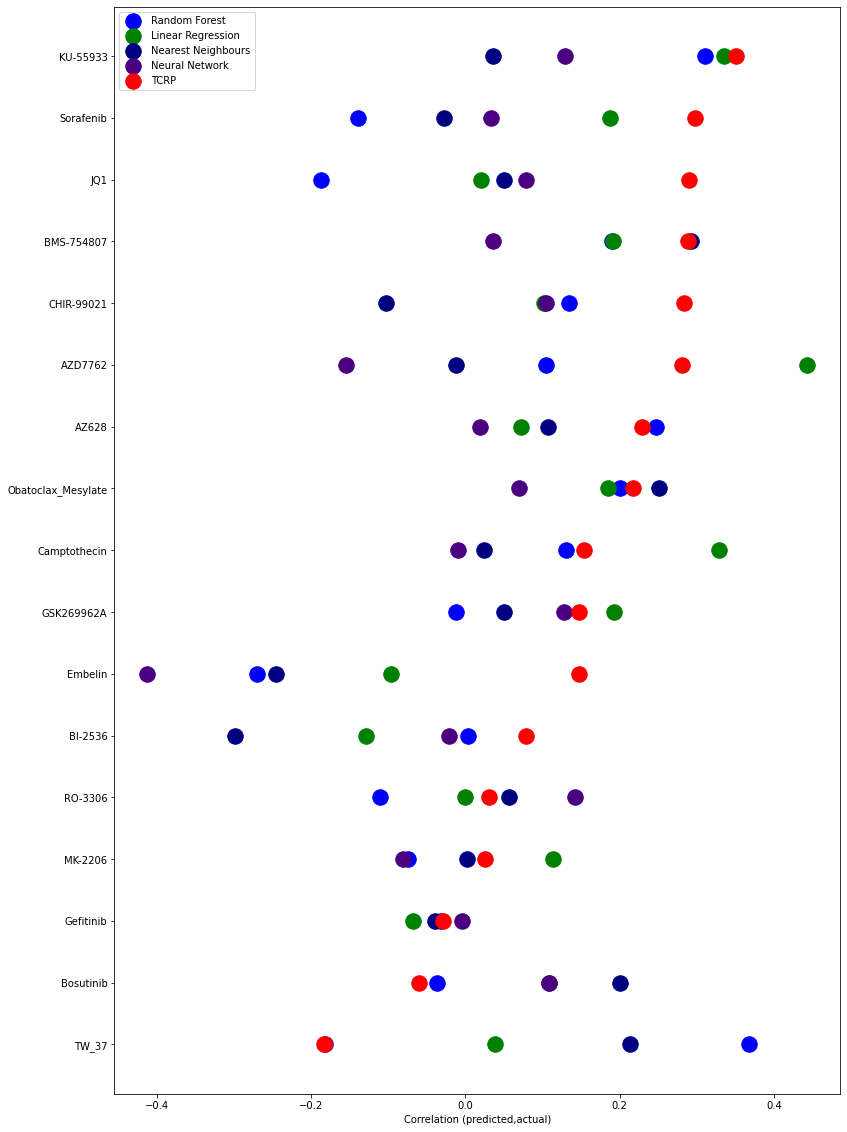

In [217]:
fig = plt.figure()
fig.set_size_inches(13,20)


RF = plt.scatter(RF_y,RF_x,color="blue",s=240)
RF.set_label("Random Forest")
linear = plt.scatter(linear_y,linear_x,color="green",s=240)
linear.set_label("Linear Regression")
KNN = plt.scatter(KNN_y,KNN_x,color="navy",s=240)
KNN.set_label("Nearest Neighbours")
NN = plt.scatter(NN_y,NN_x,color="purple",s=240)
NN.set_label("Neural Network")
TCRP = plt.scatter(TCRP_y,TCRP_x,color="red",s=240)
TCRP.set_label("TCRP")
plt.xlabel("Correlation (predicted,actual)")
plt.legend()